In [454]:
# Import program libraries
import numpy as np
import scipy.stats as sts
import matplotlib.pyplot as plt
import scipy.optimize as opt
from quantecon.markov.approximation import rouwenhorst

In [599]:
# Discritize the values of A and transform them into Markov process.
A_size = 5
A_bar = 0
A_rho = 0.885
A_sigma = np.sqrt((1- (A_rho ** 2)) * (0.64**2))
MrkChain = rouwenhorst(A_size, (1- A_rho) * A_bar, A_sigma, A_rho)
TransMat = MrkChain.P
A_sup = MrkChain.state_values
print(A_sup)
print(TransMat)
print(TransMat.sum(axis=1))

[-1.28 -0.64  0.    0.64  1.28]
[[  7.89087994e-01   1.92562587e-01   1.76217752e-02   7.16712344e-04
    1.09312891e-05]
 [  4.81406468e-02   7.97898881e-01   1.44959475e-01   8.82181891e-03
    1.79178086e-04]
 [  2.93696254e-03   9.66396498e-02   8.00846775e-01   9.66396498e-02
    2.93696254e-03]
 [  1.79178086e-04   8.82181891e-03   1.44959475e-01   7.97898881e-01
    4.81406468e-02]
 [  1.09312891e-05   7.16712344e-04   1.76217752e-02   1.92562587e-01
    7.89087994e-01]]
[ 1.  1.  1.  1.  1.]


In [668]:
# Discritize the values of K.
K_size = 400
K_min = 10.01
K_max = 30
K_vec = np.linspace(K_min, K_max, K_size)
A_vec = np.exp(A_sup)

# Set the calibrated parameters.
beta = 0.95
delta = 0.069
theta = 0.592
P = 1

# Set initial values for the value function iteration.
Vtp1 = np.zeros((K_size, A_size))
maxiter = 1000
tol_VFI = 1e-12
iter_VFI = 0
dist = 10

# We set the numer of periods to 500 and the number of simulations to 100.
A_0_ind = 2
A_0 = A_vec[A_0_ind]
T = 500
S = 100
A_series = np.zeros((T,S))
unif_series = sts.uniform.rvs(size=(T,S))
K_0 = K_vec[100]

# Define the value function iteration that generates the policy function psi.
def value_fcn(Vtp1, iter_VFI, dist, gamma):
    
    while (iter_VFI < maxiter) and (dist >= tol_VFI):
        iter_VFI += 1
    
    # Step 1: take expectation of tomorrow's value function
        Vtp1_flat = Vtp1.T.reshape((1, A_size, K_size))
        Vtp1_big = np.tile(Vtp1_flat, (A_size, 1, 1))
        TransMat_big = np.repeat(TransMat[:, :, np.newaxis], K_size, axis=2)
        EVtp1_a = (TransMat_big * Vtp1_big).sum(axis=1)
        EVtp1_flip = EVtp1_a.reshape((1, A_size, K_size))
        EVtp1 = np.tile(EVtp1_flip, (K_size, 1, 1))
    
    # Step 2: Get all other objects on the right-hand-side of Bellman equation
    # into the shape (K_size, A_size, K_size)
        K_arr = np.tile(K_vec.reshape((K_size, 1, 1)),
                    (1, A_size, K_size))
        Kpr_arr = np.tile(K_vec.reshape((1, 1, K_size)),
                      (K_size, A_size, 1))
        ConvCost = ((gamma / 2) *
                ((((Kpr_arr - (1 - delta) * K_arr) / K_arr)) ** 2) *
                K_arr)
    
        A_arr = np.tile(A_vec.reshape((1, A_size, 1)),
                    (K_size, 1, K_size))
        Profits = A_arr * (K_arr ** theta)
    
        InvCost = P * (Kpr_arr - (1 - delta) * K_arr)
    
        V_KAKpr = Profits - ConvCost - InvCost + beta * EVtp1
    
    # Step 3: Solve for the K'=psi(K,A) that maximizes using np.argmax
        Psi_ind = V_KAKpr.argmax(axis=2)
        Psi = K_vec[Psi_ind]
    
    # Step 4: Solve for V(K,A)
        V_KA = np.zeros((K_size, A_size))
        for K_ind in range(K_size):
            for A_ind in range(A_size):
                V_KA[K_ind, A_ind] = V_KAKpr[K_ind, A_ind,
                                         Psi_ind[K_ind, A_ind]]

    # Step 5: Check how close V(K,A) is to V'(K,A)
        dist = ((Vtp1 - V_KA).flatten() ** 2).sum()
    #print('Iter=', iter_VFI, ', Dist=', dist)
    
        Vtp1 = V_KA.copy()
    
    V_KA = Vtp1.copy
     
    return Psi

In [669]:
# Generate the time series of A.
for t_ind in range(T):
    for s_ind in range(S):
        prob_dist = TransMat[A_0_ind, :]
        cum_dist = prob_dist.cumsum()
        unif = unif_series[t_ind, s_ind]
        A_series[t_ind, s_ind] = A_vec[(unif < cum_dist).argmax()]

In [670]:
# Generate the time series of K.
def psi(Vtp1, iter_VFI, dist, unif_series, gamma):
    K_series = np.zeros_like(A_series)
    K_series[0,:] = K_0
    Psi = value_fcn(Vtp1, iter_VFI, dist, gamma)
    for t_ind in range(1, len(K_series)):
        for s_ind in range(S):
            A_val = A_series[t_ind - 1, s_ind]
            A_ind = np.argmin((A_val - A_vec) ** 2)
            K_val = K_series[t_ind - 1, s_ind]
            K_ind = np.argmin((K_val - K_vec) ** 2)
            K_series[t_ind, s_ind] = Psi[K_ind, A_ind]
            
    return K_series

In [671]:
# Define the data moments.
data_mom1 = 0.058
data_mom2 = 0.143
data_mom3 = 0.186
data_mom4 = 0.018
moms_data = np.array([data_mom1, data_mom2, data_mom3, data_mom4])

# Generate the model moments fromt our simulated data.
def sim_moments(Vtp1, iter_VFI, dist, unif_series, gamma):
    K_series = psi(Vtp1, iter_VFI, dist, unif_series, gamma)
    K = K_series[0:499,:]
    Kpr = K_series[1:500,:]
    I = Kpr - (1-delta) * K
    i = I / K
    a = np.log(A_series)
    mom1 = np.zeros((1,S))
    mom2 = np.zeros((1,S))
    for s in range(S):
        cov1 = np.corrcoef(i[0:498,s], i[1:499,s])
        cov2 = np.corrcoef(i[0:499,s], a[0:499,s])
        mom1[:,s] = cov1[0,1]
        mom2[:,s] = cov2[0,1]
    mom3 = (i >= 0.2).sum(axis=0) / i.shape[0]
    mom4 = (i <= -0.14).sum(axis=0) / i.shape[0]
    return mom1, mom2, mom3, mom4

In [672]:
data_mom1 = 0.058
data_mom2 = 0.143
data_mom3 = 0.186
data_mom4 = 0.018
moms_data = np.array([data_mom1, data_mom2, data_mom3, data_mom4])

In [689]:
# Create the error vector
def err_vec(Vtp1, iter_VFI, dist, unif_series, gamma):
    sim_mom1, sim_mom2, sim_mom3, sim_mom4 = sim_moments(Vtp1, iter_VFI, dist, unif_series, gamma)
    mod_mom1 = sim_mom1.mean()
    mod_mom2 = sim_mom2.mean()
    mod_mom3 = sim_mom3.mean()
    mod_mom4 = sim_mom4.mean()
    moms_model = np.array([mod_mom1, mod_mom2, mod_mom3, mod_mom4])
    err_vec = (moms_model - moms_data) / moms_data
    return err_vec

# Create the ctiterion function
def crit(params, *args):
    gamma = params
    unif_series, W = args
    err = err_vec(Vtp1, iter_VFI, dist, unif_series, gamma)
    crit_val = err @ W @ err.T
    return crit_val

In [697]:
# Set the initial values and bounds of the parameters and the weighted matrix
gamma_init = 1.2
params_init = np.array([gamma_init])
bounds = ((1e-10, 9),)
W = np.eye(4)

# Conduct SMM
smm_arg = (unif_series, W)
result = opt.minimize(crit, params_init, args=(smm_arg), bounds = bounds, options={'eps': 1.0})
gamma_smm1 = result.x
print(result)

      fun: 14.50390899634537
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.35973777])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 104
      nit: 3
   status: 0
  success: True
        x: array([ 1.45587159])


In [704]:
# Compute the two-step estimator.
err = err_vec(Vtp1, iter_VFI, dist, unif_series, gamma_smm1)
err_1 = err.reshape(1,4)
print(err_1)
omega = (err_1.T @ err_1) 
print(omega)
W_2_step = np.linalg.pinv(omega)
print(W_2_step)

[[-1.26728676  3.3089184  -0.97414183 -1.        ]]
[[  1.60601574  -4.19334848   1.23451705   1.26728676]
 [ -4.19334848  10.94894095  -3.22335583  -3.3089184 ]
 [  1.23451705  -3.22335583   0.94895231   0.97414183]
 [  1.26728676  -3.3089184    0.97414183   1.        ]]
[[ 0.00763448 -0.01993383  0.0058685   0.00602427]
 [-0.01993383  0.05204775 -0.0153228  -0.01572954]
 [ 0.0058685  -0.0153228   0.00451101  0.00463076]
 [ 0.00602427 -0.01572954  0.00463076  0.00475368]]


In [703]:
# Compute the simulated moments.
sim_mom1, sim_mom2, sim_mom3, sim_mom4 = sim_moments(Vtp1, iter_VFI, dist, unif_series, gamma_smm1)
mom_smm1 = sim_mom1.mean()
mom_smm2 = sim_mom2.mean()
mom_smm3 = sim_mom3.mean()
mom_smm4 = sim_mom4.mean()
print(mom_smm1, mom_smm2, mom_smm3, mom_smm4)

-0.0155026321741 0.616175330624 0.00480961923848 0.0


In [705]:
# Estimate the parameters using the two-step estimator.
params_init = np.array([gamma_smm1])
result = opt.minimize(crit, params_init, args = (unif_series, W_2_step), bounds = bounds, options={'eps': 1.0})
gamma_smm2 = result.x
print(result)

      fun: 0.9427708557462402
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.0075683])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 100
      nit: 4
   status: 0
  success: True
        x: array([ 1.73476726])


In [706]:
# Compute the simulated moments with the 2-step estimator.
sim_mom1, sim_mom2, sim_mom3, sim_mom4 = sim_moments(Vtp1, iter_VFI, dist, unif_series, gamma_smm2)
mom_smm1 = sim_mom1.mean()
mom_smm2 = sim_mom2.mean()
mom_smm3 = sim_mom3.mean()
mom_smm4 = sim_mom4.mean()
print(mom_smm1, mom_smm2, mom_smm3, mom_smm4)

0.0113427083994 0.623261024827 0.00452905811623 0.0


In [711]:
#plt.plot(np.arange(1, T + 1), A_series[:,0])
#plt.show()

In [712]:
K_series = psi(Vtp1, iter_VFI, dist, unif_series, gamma_smm2)
#plt.plot(np.arange(1, T + 1), K_series[:,0])
#plt.show()

In [713]:
#print(K_series[:,0])

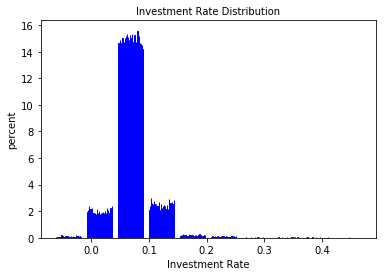

In [714]:
K = K_series[0:499,:]
Kpr = K_series[1:500,:]
I = Kpr - (1-delta) * K
i = I / K
count, bins, ignored = plt.hist(i[:,:], 10, edgecolor='blue', normed=True)
plt.title('Investment Rate Distribution', fontsize=10)
plt.xlabel('Investment Rate')
plt.ylabel('percent')
plt.show()